In [1]:
# Run eight schools
# again, this only works on startup!
import os
from functools import partial

import equinox as eqx
import jax.random as jr
import jaxtyping
import matplotlib.pyplot as plt
import optax
import pandas as pd
import seaborn as sns
import jax
with jaxtyping.install_import_hook(["cnpe", "cnpe_validation"], "beartype.beartype"):
    from cnpe.losses import AmortizedMaximumLikelihood, ContrastiveLoss
    from cnpe.train import train

    from cnpe_validation.tasks.eight_schools import EightSchoolsTask
    from cnpe_validation.tasks.tasks import AbstractTaskWithReference
    from cnpe_validation.utils import get_abspath_project_root
    

os.chdir(get_abspath_project_root())

In [2]:
seed = 0
maximum_likelihood_steps = 4000
contrastive_steps = 1000
num_contrastive = 20

key, subkey = jr.split(jr.PRNGKey(seed))
task = EightSchoolsTask(subkey)

key, subkey = jr.split(key)
true_latents, obs = task.get_latents_and_observed_and_validate(subkey)

posteriors = {}
losses = {}

key, subkey = jr.split(key)

# Pretrain using amortized maximum likelihood
loss = AmortizedMaximumLikelihood(task.model.reparam())

optimizer = optax.apply_if_finite(
    optax.chain(
        optax.adam(optax.linear_schedule(1e-3, 1e-5, maximum_likelihood_steps)),
        optax.clip_by_global_norm(5),
    ),
    max_consecutive_errors=100,
)
method_name = "maximum likelihood"
key, subkey = jr.split(key)
posteriors[method_name], losses[method_name] = train(
    subkey,
    guide=task.guide,
    loss_fn=loss,
    steps=maximum_likelihood_steps,
    optimizer=optimizer,
)


optimizer = optax.apply_if_finite(
    optax.chain(
        optax.adam(optax.linear_schedule(1e-3, 1e-4, maximum_likelihood_steps)),
        optax.clip_by_global_norm(5),
    ),
    max_consecutive_errors=100,
)

# Fine tune with contrastive loss
for stop_grad in [False, True]:
    method_name = f"NPE-PP (stop grad={stop_grad})"

    loss = ContrastiveLoss(
        model=task.model.reparam(),
        obs=obs,
        n_contrastive=num_contrastive,
        stop_grad_for_contrastive_sampling=stop_grad,
    )

    key, subkey = jr.split(key)

    posteriors[method_name], losses[method_name] = train(
        subkey,
        guide=posteriors["Maximum Likelihood"],
        loss_fn=loss,
        steps=contrastive_steps,
        optimizer=optimizer,
    )


100%|██████████| 1000/1000 [00:22<00:00, 44.72it/s, loss=17.6]


In [3]:
def compute_true_latent_prob(true_latents, posteriors, model, obs):  # For a single latent
    return {
        k: posterior.log_prob_original_space(
            latents=true_latents,
            model=model,
            obs=obs,
        )
        for k, posterior in posteriors.items()
    }

compute_true_latent_prob = partial(
    compute_true_latent_prob,
    posteriors=posteriors,
    model=task.model,
    obs=obs,
    )

if isinstance(task, AbstractTaskWithReference):  # Batch of "true" samples
    compute_true_latent_prob = eqx.filter_vmap(compute_true_latent_prob)

log_prob_true = compute_true_latent_prob(true_latents)


([0, 1, 2],
 [Text(0, 0, 'contrastive (stop grad=False)'),
  Text(1, 0, 'contrastive (stop grad=True)'),
  Text(2, 0, 'maximum likelihood')])

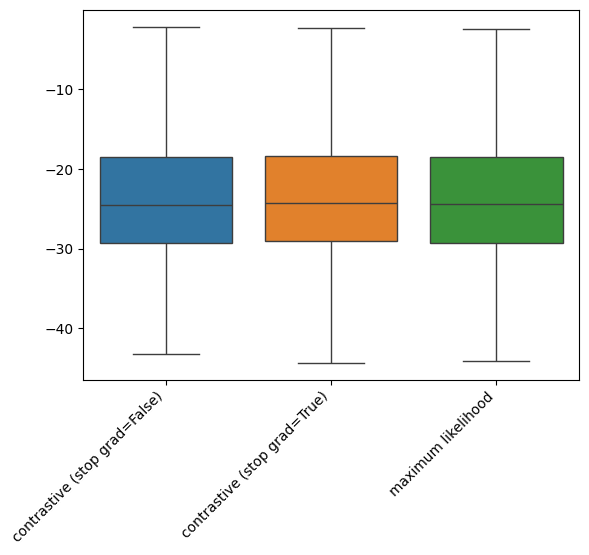

In [4]:
sns.boxplot(pd.DataFrame(log_prob_true), showfliers="")
plt.xticks(rotation=45, ha='right')

In [5]:
key, subkey = jr.split(key)

posterior_samples = {}

key, subkey = jr.split(key)
for k, posterior in posteriors.items():
    posterior_samples[k] = jax.vmap(partial(posterior.sample, obs=obs))(
        jr.split(subkey, 5000),
        )

posterior_samples = {
    k: eqx.filter_vmap(task.model.latents_to_original_space)(samps)
    for k, samps in posterior_samples.items()
}

In [10]:
key, subkey = jr.split(key)
prior_samples = jax.vmap(task.model.reparam(set_val=False).sample_prior)(
    jr.split(key, 5000),
    )

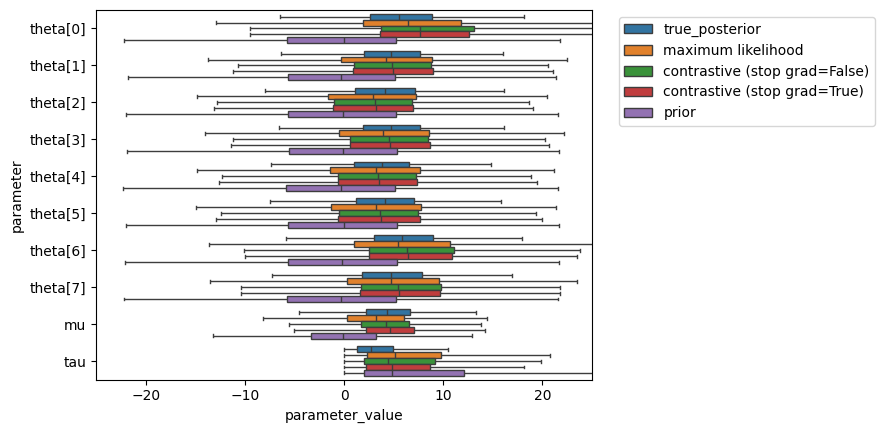

In [11]:
samples = {
    "true_posterior": true_latents,
} | posterior_samples | {"prior": prior_samples}

dfs = []
for k, samps in samples.items():
    columns = {}
    for name, arr in samps.items():
        if arr.ndim == 1:
            columns[name] = arr
        
        if arr.ndim == 2:
            for i in range(arr.shape[-1]):
                columns[f"{name}[{i}]"] = arr[:, i]
    df = pd.DataFrame(columns)
    df["source"] = k
    dfs.append(df)

df = pd.concat(dfs)
df = df.melt(id_vars="source", var_name="parameter", value_name="parameter_value")
sns.boxplot(data=df, x="parameter_value", y="parameter", hue="source", showfliers="")
plt.xlim(-25, 25)
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")